# Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn [link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html).
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature_importances_ attribute of your random forest and discuss the obtained results.

## Tackling plan
1. We use fetch_20newsgroups function from sklearn.datasets to get the data specifying that we want the entire dataset as we will split it for train/test ourselves.
2. We keep only data that is of interest for us (content of the news and labels) and import it in a dataframe.
3. We use TfidfVectorizer to compute TD-IDF features for every article.
4. We train a RandomForestClassifier on the TF-IDF feature vectors. 
5. We use GridSearchCV frunction from sklearn.model_selection in order to fine tune the hyperparameters of our model.
6. We make use of the confusion_matrix function from sklearn.metrics to compute the confusion matrix
7. We have a look at the feature\_importances\_ of our model by plotting the top 20 most important features and also looking at the distribution of the values by studying the quartiles.

## Used libraries

In [4]:
import math
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Preparing the dataset

Firstly we get the dataset by using sklearn functionality. We specify that we want the entire dataset and pass a relative path for the download folder.

In [5]:
data_folder = os.path.join('.','data')
newsgroups_train = fetch_20newsgroups(subset='all', data_home=data_folder)

The obtained data is enclosed in a specific sklearn object, namely Bunch which is basically a dictionary.

In [6]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

As we can see it contains multiple entries out of which we are interested in:

* **data** which is a list with the actual content 
* **target** containing the labels for each data entry
* **target_names** containing the textual representation(names) of the labels, useful when we will analyze the output of the classifier

We will create a dataframe with specifically this fields.

In [7]:
df = pd.DataFrame(data={'doc':newsgroups_train['data'], 'label':newsgroups_train['target']})
labels_names = newsgroups_train['target_names']

In order to have a better look at the data, we would like to show it not truncated therefore we remove the max column width limit of pandas display option.

In [8]:
pd.set_option('display.max_colwidth', -1)

In [9]:
df[:3]

,doc,label
0,"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",10
1,"From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which high-performance VLB video card?\nSummary: Seek recommendations for VLB video card\nNntp-Posting-Host: midway.ecn.uoknor.edu\nOrganization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA\nKeywords: orchid, stealth, vlb\nLines: 21\n\n My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n\n-- \n | Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu) | \n --+-- ""Now I, Nebuchadnezzar, praise and exalt and glorify the King --+-- \n | of heaven, because everything he does is right and all his ways | \n | are just."" - Nebuchadnezzar, king of Babylon, 562 B.C. | \n",3
2,"From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject: Re: ARMENIA SAYS IT COULD SHOOT DOWN TURKISH PLANES (Henrik)\nLines: 95\nNntp-Posting-Host: viktoria.dsv.su.se\nReply-To: hilmi-er@dsv.su.se (Hilmi Eren)\nOrganization: Dept. of Computer and Systems Sciences, Stockholm University\n\n\n\n\n|>The student of ""regional killings"" alias Davidian (not the Davidian religios sect) writes:\n\n\n|>Greater Armenia would stretch from Karabakh, to the Black Sea, to the\n|>Mediterranean, so if you use the term ""Greater Armenia"" use it with care.\n\n\n\tFinally you said what you dream about. Mediterranean???? That was new....\n\tThe area will be ""greater"" after some years, like your ""holocaust"" numbers......\n\n\n\n\n|>It has always been up to the Azeris to end their announced winning of Karabakh \n|>by removing the Armenians! When the president of Azerbaijan, Elchibey, came to \n|>power last year, he announced he would be be ""swimming in Lake Sevan [in \n|>Armeniaxn] by July"".\n\t\t*****\n\tIs't July in USA now????? Here in Sweden it's April and still cold.\n\tOr have you changed your calendar???\n\n\n|>Well, he was wrong! If Elchibey is going to shell the \n|>Armenians of Karabakh from Aghdam, his people will pay the price! If Elchibey \n\t\t\t\t\t\t ****************\n|>is going to shell Karabakh from Fizuli his people will pay the price! If \n\t\t\t\t\t\t ******************\n|>Elchibey thinks he can get away with bombing Armenia from the hills of \n|>Kelbajar, his people will pay the price. \n\t\t\t ***************\n\n\n\tNOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE.\n\t\n\tSHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH\n\t\t\t\t\t\t **************\n\tBEING RAPED, KILLED AND TORTURED BY THE ARMENIANS??????????\n\t\n\tHAVE YOU HEARDED SOMETHING CALLED: ""GENEVA CONVENTION""???????\n\tYOU FACIST!!!!!\n\n\n\n\tOhhh i forgot, this is how Armenians fight, nobody has forgot\n\tyou killings, rapings and torture against the Kurds and Turks once\n\tupon a time!\n \n \n\n|>And anyway, this ""60 \n|>Kurd refugee"" story, as have other stories, are simple fabricat

### Note
One thing we notice is that the data has a special structure: it containes headers and signature blocks. This will have an impact on the generalization power of our classifier. For a more realistic approach we can remove these blocks and then train a classifier on the data. 

In [7]:
# number of data entries that have a header starting with the source of the email
df.doc.str.startswith('From:').sum()

18038

## Creating the feature vectors

As indicated in the task statement we will use the TfidfVectorizer. This is indeed a good choice for classification as it can successfully filter stop-words by weighting down the frequent terms across the entire corpus.

In [8]:
vectorizer = TfidfVectorizer()
featurized_data = vectorizer.fit_transform(df.doc)

In [9]:
featurized_data.shape

(18846, 173762)

In [10]:
rate = featurized_data.nnz/featurized_data.shape[0]
rate

156.6663482967208

In [11]:
print('We can see that our feature vectors lie in an {}-dimmensional space\
 out of which only an average of {} components are non-zero'.format(featurized_data.shape[1], int(rate)))

We can see that our feature vectors lie in an 173762-dimmensional space out of which only an average of 156 components are non-zero


## Splitting the data into train, validation and test

### Small note

Because the feature vectors for the documents are very high dimmensional and are stored as a *sparse matrix*, we will not create a dataframe from them because we would have to convert it to a dense matrix which would require quite a lot of memory. Instead, we will keep two different numpy arrays, one for labels and one for data, where the label in row *i* corresponds to the data in row *i*.

In [12]:
X = featurized_data

y = df.label.values

### Splitting the data

Because we will use the GridSearchCV function to fine-tune our model's hyperparameters, we will split our data only into train and test sets. This is because of how is implemented GridSearchCV, which we will discuss a little later.

For this, we will use the train_test_split function from sklearn which splits the data into random train and test subsets according to the test_size parameter which specifies the fraction of data we want as test. Additionally, we would like to keep the same distribution across the classes in order to not introduce a sampling bias therefore we will use the parameter stratify to specify the class for each data entry upon which the stratified sampling will be done. 

By stratified sampling we understand that instead of just randomly extracting 10% of the data for test, we will look at the labels and for each class we will extract 10% as test data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=777)

### Class distribution

We will now have a look at the class distribution across our train and test datasets.

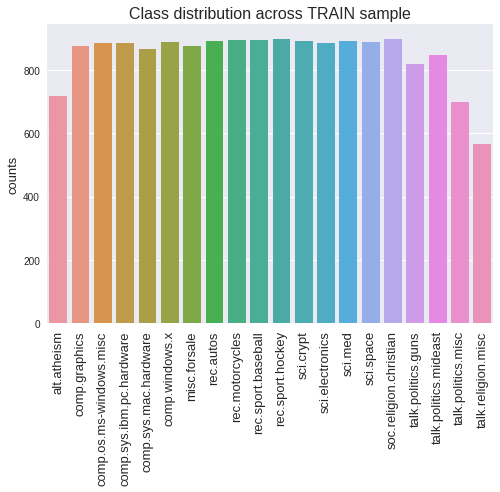

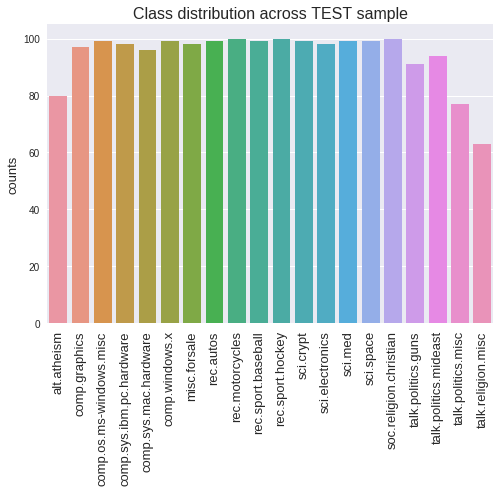

In [14]:
import matplotlib.pyplot as plt
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)


plt.figure()
plt.title('Class distribution across TRAIN sample', fontsize=16)
plt.ylabel('counts', fontsize=13)
g = sns.barplot(x=labels_names, y=train_class_counts)
g.set_xticklabels(labels_names, rotation=90, fontsize=13)
plt.show()

plt.figure()
plt.title('Class distribution across TEST sample', fontsize=16)
plt.ylabel('counts', fontsize=13)
g = sns.barplot(x=labels_names, y=test_class_counts)
g.set_xticklabels(labels_names,rotation=90, fontsize=13)
plt.show()

We can remark that almost all classes are evenly distributed across the data, a more noticeable exception is the talk.religion.misc class which appears to be about a thirds less frequent.

As expected by the train_test_split function, the data's distribution is kept across the two datasets.

## Training and evaluating the model

We will now train a RandomForestClassifier in order to predict the label for the news emails.

In order to fine tune the parameters, we will use cross-validation. Given that the parameters to tune are already chosen, one important decision that is left to be made here is the range of the parameters. For this process we will have an iterative approach in which we will start with some coarse values and after each iteration we will fine-graine our intervals.

>**n_estimators** as discussed in class and from literature we will firstly pick values in the range [10,500]

>**max_depth** will range between [5,40]

Another decision with high importance is the evaluation function to be used when tuning our hyperparameters. Given that the data is reasonably distributed across the classes we will use the simple accuracy metric for evaluation. The accuracy metric returns the fraction of matching labels between the predicted labels and actual labels. In other words, it counts the fraction of data entries we classified correctly.

In order to tune our parameters we will use the sklearn function GridSearchCV.
We pass it a dictionary with parameters values containing an array of values for each parameter and it will iterate over all combinations of these values. It will do, by default, a 3-fold cross-validation to evaluate the current combination.
Given that our estimator is a classifier (RandomForestClassifier) the cross-validation will be a stratified-3-fold cross validation.
Additionally, we will specify the scoring method to be the above mentioned accuracy metric and we will parallelize the training over 4 thread using n_jobs parameter.

One last thing to be mentioned is that GridSearchCV will return the best classifier trained on the entire dataset

In [15]:
rfc = RandomForestClassifier(n_jobs=2, random_state=777)

parameters = {'n_estimators':[10, 50, 100, 200, 300, 400, 500], 'max_depth':[5,10,20,30,40]}

clf = GridSearchCV(rfc, parameters, n_jobs=4, scoring='accuracy', verbose=True)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed: 16.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [10, 50, 100, 200, 300, 400, 500], 'max_depth': [5, 10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [16]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=2, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

In [17]:
clf.grid_scores_

/home/doru/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.29745, std: 0.00728, params: {'max_depth': 5, 'n_estimators': 10},
 mean: 0.54549, std: 0.01415, params: {'max_depth': 5, 'n_estimators': 50},
 mean: 0.62190, std: 0.00845, params: {'max_depth': 5, 'n_estimators': 100},
 mean: 0.67089, std: 0.00203, params: {'max_depth': 5, 'n_estimators': 200},
 mean: 0.68923, std: 0.00326, params: {'max_depth': 5, 'n_estimators': 300},
 mean: 0.70485, std: 0.00107, params: {'max_depth': 5, 'n_estimators': 400},
 mean: 0.71028, std: 0.00326, params: {'max_depth': 5, 'n_estimators': 500},
 mean: 0.40917, std: 0.01287, params: {'max_depth': 10, 'n_estimators': 10},
 mean: 0.64595, std: 0.00446, params: {'max_depth': 10, 'n_estimators': 50},
 mean: 0.70562, std: 0.00801, params: {'max_depth': 10, 'n_estimators': 100},
 mean: 0.72908, std: 0.00762, params: {'max_depth': 10, 'n_estimators': 200},
 mean: 0.74082, std: 0.00692, params: {'max_depth': 10, 'n_estimators': 300},
 mean: 0.74848, std: 0.00616, params: {'max_depth': 10, 'n_estimators': 400

We can notice from the logs above that the maximum accuracy value was reached at the edge of our parameters values intervals. This is a good indicator that we should explore more values beyond our initial intervals.

In [18]:
rfc = RandomForestClassifier(n_jobs=2, random_state=777)

parameters = {'n_estimators':[400, 500, 600], 'max_depth':[40, 50, 60]}

clf = GridSearchCV(rfc, parameters, n_jobs=4, pre_dispatch=4, scoring='accuracy', verbose=True)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 22.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [400, 500, 600], 'max_depth': [40, 50, 60]},
       pre_dispatch=4, refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [19]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=2, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

In [20]:
clf.cv_results_

{'mean_fit_time': array([ 113.12104877,  134.38394332,  159.42427421,  144.29609704,
         176.85852551,  218.07995764,  180.74239119,  226.09119336,
         234.34279323]),
 'mean_score_time': array([ 4.82946674,  5.22873386,  5.89357789,  4.14888716,  5.21538321,
         6.16988921,  4.03084302,  5.52218962,  4.63658301]),
 'mean_test_score': array([ 0.82282884,  0.82483344,  0.82595366,  0.83102411,  0.83255704,
         0.83467956,  0.83385414,  0.83656624,  0.838335  ]),
 'mean_train_score': array([ 0.98352045,  0.98393339,  0.98490612,  0.99168639,  0.99221704,
         0.99248238,  0.99587262,  0.99584303,  0.99619686]),
 'param_max_depth': masked_array(data = [40 40 40 50 50 50 60 60 60],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [400 500 600 400 500 600 400 500 600],
              mask = [False False False False False False False False False],
        fill_value = ?),
 

Again, the best model has the hyper-parameters at the edge of our searching intervals but this time, in order to avoid overfitting and because of the long train times, the model we will not look further and use this result. 

## Using the model 

We will now take a look at the confusion matrix for the test dataset. In order to do so, we predict the labels for our test dataset and use the sklearn metrics functionalities, namely the confusion_matrix function, along with the real labels to compute the confusion matrix.

Given that the GridSearchCV is a wrapper over the actual estimator, in order to easily analyse feature importances, we will get a reference to the best estimator, i.e. the best RandomForestClassifier.

In [21]:
forest_clf = clf.best_estimator_

In [22]:
y_pred = forest_clf.predict(X_test)

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)

For an easier analysis of the confusion matrix, we will use a clear visual representation of it.

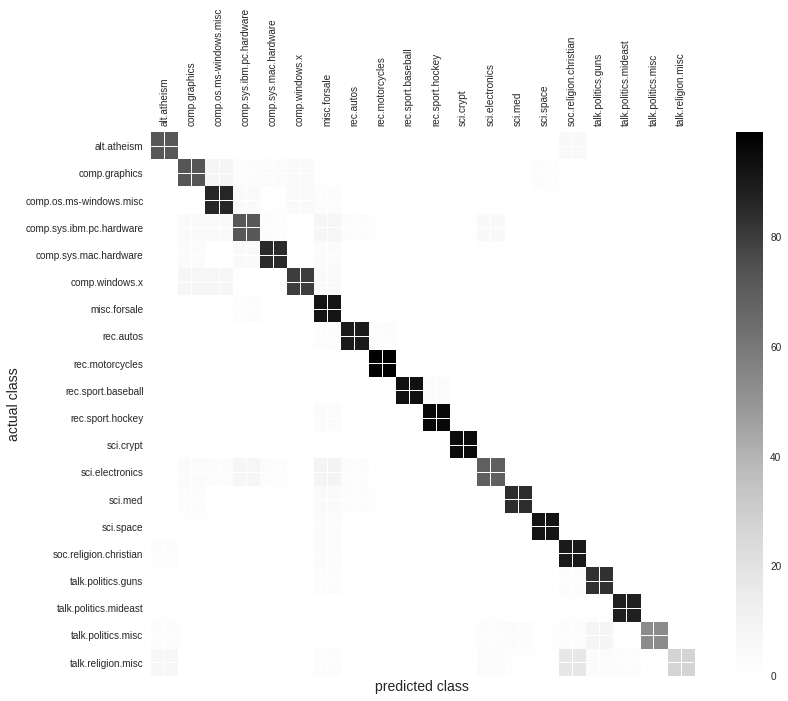

In [24]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
cax = ax.matshow(conf_mat)
fig.colorbar(cax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.xaxis.tick_top()

plt.xlabel('predicted class', fontsize=14)
plt.ylabel('actual class', fontsize=14)

plt.xticks(range(20), labels_names, rotation='vertical')
plt.yticks(range(20), labels_names)

plt.show()

To help our analysis, we will also look at the accuracy score of our model.

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.85888594164456233

We can observe from the confusion matrix that our classifier performs fairly well. Looking at the misclassified data entries, we can see that most of them are examples with related subjects: comp.windows.x and comp.grafics or comp.windows.x and comp.os.ms-windows.misc. Also, the worst classified examples from talk.religion.misc are labeled as soc.religion.christian which is explainable given that having similar subjects, many words are common between the texts but not present in the other classes.

We can therefore state that even if our classifier does a decent job, it still has difficulties with subject-related documents. This might be explainable by the number of different subjects across our corpus. Hence, the IDF part of our vectorizer which penalizes words with high frequency across all documents, will not penalize enough words that have a considerable frequency in subject-related documents.

## Top 20 most important features
We will now have a look at the 20 features with the biggest impact on our classifier

In order to determine the 20 most important features across our entire decision trees forest, we will average the feature importances of each decision tree. This way we create an indicator over the entire model and we will also have a confidence interval. The same approach is used by the library to compute the feature importances for the RandomForestClassifier.

In [26]:
# we obtain references to our decision trees
decision_trees = forest_clf.estimators_
# we create a matrix where row i containes the feature importances
# corresponding to decision tree i
feature_importances_across_trees = []
for tree in decision_trees:
    feature_importances_across_trees.append(tree.feature_importances_)
    
# we compute the mean and std of the feature importances
# across all the decision trees
mean = np.mean(feature_importances_across_trees, axis=0)
std = np.std(feature_importances_across_trees, axis=0)
sorted_indices = np.argsort(mean)[::-1]

Now that we determined the top most important features, we want to create a dataframe with the importance of the 20 top features across all decision trees in order to see how the values are distributed.

To extract more easily the importances for these features using a list of positions as index, we create a numpy array from the feature importances across the decision trees and then we select only those columns corresponding to the features in top 20 most important.

In [64]:
feat_imp_np = np.array(feature_importances_across_trees)[:,sorted_indices[:top_features]]

After we created the numpy array with the importances of the top 20 features, we use it to obtain the desired dataframe.

In [66]:
df = pd.DataFrame(feat_imp_np)
df.columns = feature_names[sorted_indices[:top_features]]

Now that we have our dataframe created, we can use the describe method to have a better look at the distribution of the feature importances across the decision trees.

In [67]:
df.describe()

,windows,dod,sale,clipper,car,bike,israel,hockey,god,encryption,space,re,team,rutgers,baseball,of,game,athos,cars,the
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.005288,0.005188,0.004980,0.004132,0.003810,0.003761,0.003582,0.003529,0.003309,0.003255,0.003240,0.003016,0.002922,0.002883,0.002711,0.002657,0.002584,0.002554,0.002511,0.002478
std,0.009046,0.010389,0.010767,0.009056,0.007018,0.008153,0.007013,0.006998,0.005920,0.007190,0.006052,0.003926,0.005672,0.006335,0.005213,0.003125,0.005445,0.005864,0.005200,0.002492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000349,0.000000,0.000051,0.000000,0.000140,0.000000,0.000000,0.000000,0.000210,0.000000,0.000087,0.000930,0.000000,0.000000,0.000000,0.001051,0.000000,0.000000,0.000000,0.001135
50%,0.001575,0.000683,0.000690,0.000588,0.000845,0.000399,0.000419,0.000582,0.000889,0.000452,0.000709,0.001585,0.000457,0.000367,0.000576,0.001696,0.000464,0.000072,0.000197,0.001779
75%,0.005237,0.004555,0.002946,0.003138,0.003452,0.002942,0.003540,0.003352,0.003761,0.002790,0.003201,0.003043,0.002606,0.002048,0.002495,0.002808,0.002130,0.001664,0.001940,0.002638
max,0.044330,0.057406,0.058470,0.059699,0.039471,0.044611,0.041434,0.046453,0.037427,0.044768,0.043432,0.019394,0.030083,0.041090,0.030828,0.023886,0.037616,0.037734,0.027423,0.015284


We can remark from the values of the quartiles that the features don't have a big importance across all the decision trees, but rather for a subset of it, aproximatively for 25%. This is explainable because decision trees giving importances to different features helps reducing the overfitting characteristic to a decision tree.

We can also notice that the mean is comparable with the value of the third quantile which sustains the previous remark regarding the big importance for 25% of the decision trees.

What is now left is to plot the 20 most important features with their deviations.

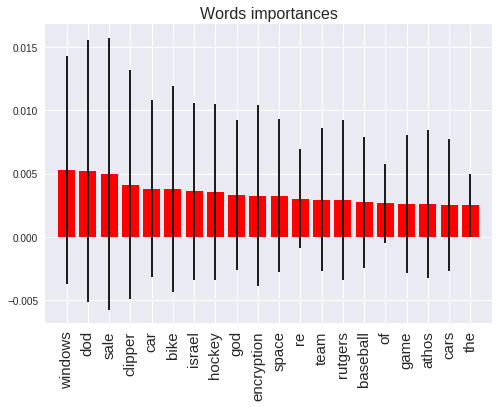

In [27]:
feature_names = np.array(vectorizer.get_feature_names())
top_features = 20 
plt.figure()
plt.title("Words importances", fontsize=16)
plt.bar(range(top_features), mean[sorted_indices[:top_features]],
       color="r", yerr=std[sorted_indices[:top_features]], align="center")
plt.xticks(range(top_features), feature_names[sorted_indices[:top_features]], rotation='vertical', fontsize=15)
plt.xlim([-1, top_features])
plt.show()

In [19]:
labels_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

First thing we notice is the **high variance** in the importance of the features. This is explained by the big number of decision trees in our classifier (600). 

If we try to analyze the feature importances looking at the words they correspond to, we notice that the classifier is able to identify some topics/key-words in the documents and diferentiate them based on these topics. For example **windows**, which has the biggest averaged importance, is strongly related to the comp.\* class of subjects. Another example that our classifier manages to select proper keywords from the docs is the high importance our classifier give to the word **god** as it is reasonably to assume that this words is more specific to subjects **alt.atheism** or **soc.religion.christian** than, say, **comp.graphics** which makes it a good feature to differentiate upon.